<a href="https://colab.research.google.com/github/keerthireddy-28/ExplainableAi/blob/main/LabAssignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas scikit-learn lime matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d776e62ddf37745d0a051ca89556d8dd3c4887a0a4adc93e0cd6c04b3eaccbb0
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


 Model training completed.

 LIME explanation for first test client:
month_oct <= 0.00: -0.3382
education_illiterate <= 0.00: -0.1357
month_dec <= 0.00: -0.0823
5191.00 < nr_employed <= 5228.10: -0.0772
179.00 < duration <= 320.00: -0.0658
poutcome_success <= 0.00: -0.0474
1.10 < emp_var_rate <= 1.40: -0.0472
job_housemaid <= 0.00: -0.0443
job_self-employed <= 0.00: 0.0319
job_unknown <= 0.00: 0.0290


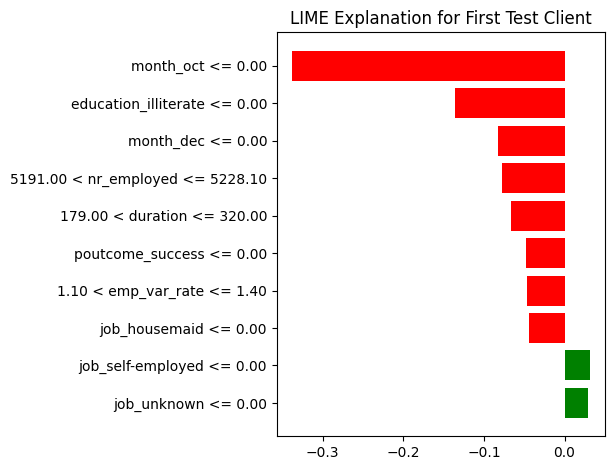


=== Marketing Insights ===
- Features like previous campaign outcome, contact channel, month, and balance strongly affect subscription.
- LIME shows individual reasons: e.g., a client may say 'yes' due to being contacted in a good month,
  but 'no' if contacted too many times or long since last contact.
- Use global patterns (feature importance) for segmentation and local patterns (LIME) for personalization.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from lime.lime_tabular import LimeTabularExplainer

# ----------------------------
# 1. Load dataset
# ----------------------------
# Use your path here
df = pd.read_csv("/content/banking.csv")

# Target column should be 'y' with values 0/1
y = df['y']
X = df.drop(columns=['y'])

cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(exclude=['object']).columns

# ----------------------------
# 2. Train Gradient Boosting
# ----------------------------
preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ('num', 'passthrough', num_cols)
])

model = Pipeline([
    ('preprocess', preprocess),
    ('clf', GradientBoostingClassifier(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
model.fit(X_train, y_train)

print(" Model training completed.")

# ----------------------------
# 3. Explain with LIME
# ----------------------------
# Get transformed feature names
ohe = model.named_steps['preprocess'].named_transformers_['cat']
ohe_names = ohe.get_feature_names_out(cat_cols)
feature_names = list(ohe_names) + list(num_cols)

# Create a wrapper function for predict_proba that handles the ColumnTransformer
def predict_proba_wrapper(data):
    # LIME passes a numpy array in the transformed space (same as X_train_trans)
    # We need to pass this transformed data directly to the classifier's predict_proba
    return model.named_steps['clf'].predict_proba(data)


X_train_trans = model.named_steps['preprocess'].transform(X_train)

explainer = LimeTabularExplainer(
    training_data=X_train_trans,
    feature_names=feature_names,
    class_names=['no', 'yes'],
    discretize_continuous=True,
    random_state=42
)

# Pick one sample client from test set
sample = X_test.iloc[0:1]
sample_trans = model.named_steps['preprocess'].transform(sample)[0]

exp = explainer.explain_instance(
    data_row=sample_trans,
    predict_fn=predict_proba_wrapper,
    num_features=10
)

print("\n LIME explanation for first test client:")
for feat, val in exp.as_list(label=1):
    print(f"{feat}: {val:.4f}")

# ----------------------------
# 4. Visualize contributions
# ----------------------------
exp.as_pyplot_figure(label=1)
plt.title("LIME Explanation for First Test Client")
plt.tight_layout()
plt.show()

# ----------------------------
# 5. Marketing insights
# ----------------------------
print("\n=== Marketing Insights ===")
print("- Features like previous campaign outcome, contact channel, month, and balance strongly affect subscription.")
print("- LIME shows individual reasons: e.g., a client may say 'yes' due to being contacted in a good month,")
print("  but 'no' if contacted too many times or long since last contact.")
print("- Use global patterns (feature importance) for segmentation and local patterns (LIME) for personalization.")

Target split:
 MedHouseVal
1    10325
0    10315
Name: count, dtype: int64

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.8876    0.8992    0.8933      2063
           1     0.8979    0.8862    0.8920      2065

    accuracy                         0.8927      4128
   macro avg     0.8927    0.8927    0.8927      4128
weighted avg     0.8928    0.8927    0.8927      4128


🔎 LIME explanation for one house:
33.94 < Latitude <= 34.26: 0.1435
2.57 < MedInc <= 3.53: -0.1133
AveOccup > 3.29: -0.1050
18.00 < HouseAge <= 29.00: 0.0097
1168.00 < Population <= 1730.00: 0.0088
1.05 < AveBedrms <= 1.10: 0.0083
-118.49 < Longitude <= -118.01: -0.0053
AveRooms <= 4.44: -0.0005


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


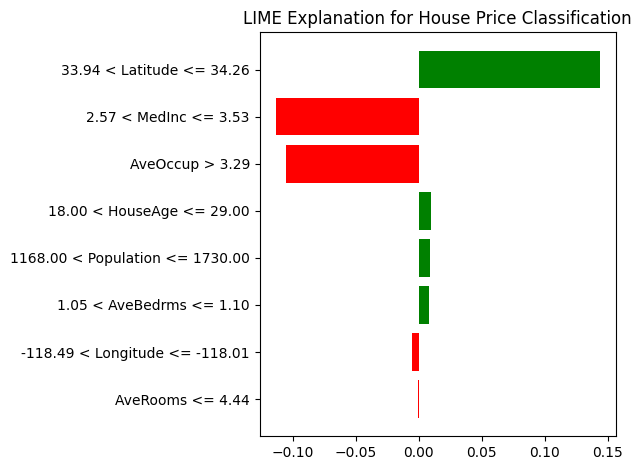

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from lime.lime_tabular import LimeTabularExplainer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# ----------------------------
# 1. Load dataset
# ----------------------------
california = fetch_california_housing(as_frame=True)
df = california.frame

# ----------------------------
# 2. Prepare binary target
# ----------------------------
# Let's classify houses as expensive (1) if price >= median, else cheap (0)
median_price = df['MedHouseVal'].median()
y = (df['MedHouseVal'] >= median_price).astype(int)
X = df.drop(columns=['MedHouseVal'])

print("Target split:\n", y.value_counts())

# ----------------------------
# 3. Train Random Forest
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
rf_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42))
])

rf_clf.fit(X_train, y_train)

# Evaluate
y_pred = rf_clf.predict(X_test)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

# ----------------------------
# 4. Apply LIME
# ----------------------------
feature_names = X.columns.tolist()

explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    class_names=['Cheap', 'Expensive'],
    discretize_continuous=True,
    random_state=42
)

# Pick one sample house
sample = X_test.iloc[0]
exp = explainer.explain_instance(
    data_row=sample.values,
    predict_fn=rf_clf.predict_proba,
    num_features=8
)

print("\n🔎 LIME explanation for one house:")
for feat, val in exp.as_list(label=1):
    print(f"{feat}: {val:.4f}")

# ----------------------------
# 5. Visualize explanation
# ----------------------------
exp.as_pyplot_figure(label=1)
plt.title("LIME Explanation for House Price Classification")
plt.tight_layout()
plt.show()